<a href="https://colab.research.google.com/github/rodwol/Deep_Learning_Pretrained_Models/blob/main/Summative_Assignment__Rodas_Goniche.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/dataset')

Mounted at /content/dataset


In [ ]:
import kagglehub

In [ ]:
import zipfile

In [ ]:
data1 = kagglehub.dataset_download("techsash/waste-classification-data")
data2 = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

100%|██████████| 427M/427M [00:19<00:00, 22.4MB/s]

Extracting files...


100%|██████████| 82.0M/82.0M [00:04<00:00, 17.4MB/s]

Extracting files...


In [ ]:
import zipfile
import os

def prepare_dataset(dataset_path, extract_to):
    if zipfile.is_zipfile(dataset_path):
        print(f"Extracting {dataset_path} ...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
    elif os.path.isdir(dataset_path):
        print(f"Dataset is already extracted: {dataset_path}")
        os.makedirs(extract_to, exist_ok=True)
        os.system(f"cp -r '{dataset_path}'/* '{extract_to}'")
    else:
        print(f"Invalid dataset path: {dataset_path}")

extract_dir = "/content/extracted_datasets"
os.makedirs(extract_dir, exist_ok=True)

prepare_dataset(data1, os.path.join(extract_dir, "waste-classification-data"))
prepare_dataset(data2, os.path.join(extract_dir, "garbage-classification"))

Dataset is already extracted: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1
Dataset is already extracted: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2


In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import os

train_dir = '/content/extracted_datasets/waste-classification-data/DATASET/TRAIN'
val_dir = '/kaggle/working/DATASET/VAL'
os.makedirs(val_dir, exist_ok=True)

# Loop through each class (O, R)
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_files, val_files = train_test_split(images, test_size=0.2, random_state=42)

    # Create subfolder for class
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move validation files
    for f in val_files:
        src = os.path.join(class_path, f)
        dst = os.path.join(val_dir, class_name, f)
        shutil.copy(src, dst)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train data generator with realistic augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # small random rotations
    width_shift_range=0.1,      # horizontal shifts
    height_shift_range=0.1,     # vertical shifts
    shear_range=0.1,            # slant the image
    zoom_range=0.2,             # zoom in/out
    brightness_range=[0.8, 1.2],# random brightness
    horizontal_flip=True,       # flip horizontally
    fill_mode='nearest'         # fill empty pixels
)

In [ ]:
# Validation/test data — only rescale
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    '/content/extracted_datasets/waste-classification-data/DATASET/TRAIN',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    '/kaggle/working/DATASET/VAL',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/extracted_datasets/waste-classification-data/DATASET/TEST',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 22564 images belonging to 2 classes.
Found 4513 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [ ]:
print("Classes:", train_generator.class_indices)
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)


Classes: {'O': 0, 'R': 1}
Train samples: 22564
Validation samples: 4513
Test samples: 2513


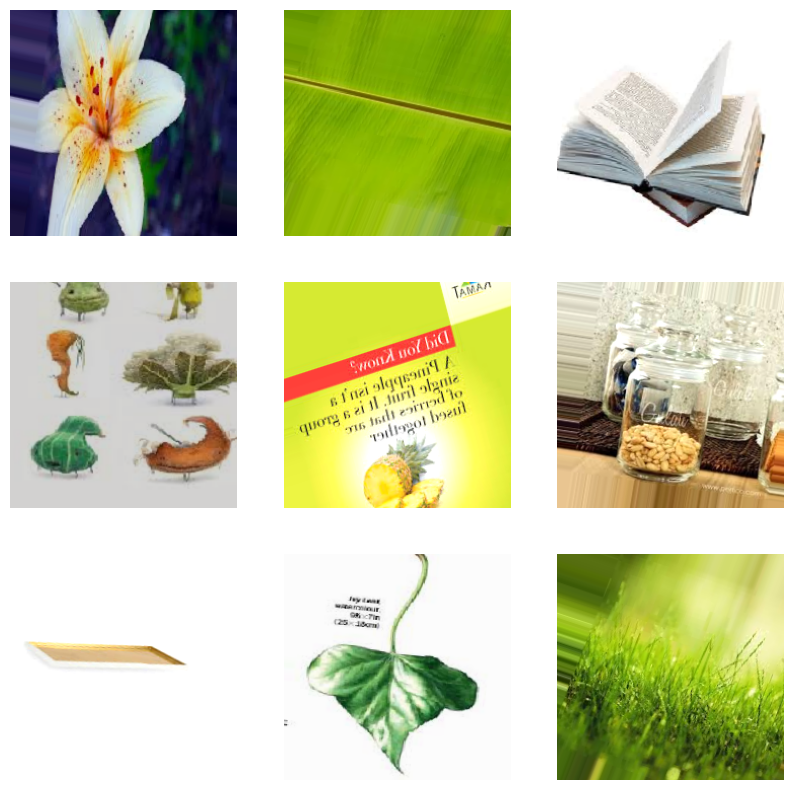

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of augmented images
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

In [ ]:
# importing the needed libraries for EfficientNetBO
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Build the model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Freeze base model layers for feature extraction
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# callbacks
checkpoint = ModelCheckpoint(
    'efficientnetb0_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# TRAIN FEATURE EXTRACTOR
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.5432 - loss: 0.6963
Epoch 1: val_accuracy improved from -inf to 0.55684, saving model to efficientnetb0_best.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 392s 514ms/step - accuracy: 0.5432 - loss: 0.6963 - val_accuracy: 0.5568 - val_loss: 0.6867
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.5584 - loss: 0.6869
Epoch 2: val_accuracy did not improve from 0.55684
706/706 ━━━━━━━━━━━━━━━━━━━━ 320s 453ms/step - accuracy: 0.5584 - loss: 0.6869 - val_accuracy: 0.5568 - val_loss: 0.6866
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5579 - loss: 0.6868
Epoch 3: val_accuracy did not improve from 0.55684
706/706 ━━━━━━━━━━━━━━━━━━━━ 315s 444ms/step - accuracy: 0.5579 - loss: 0.6868 - val_accuracy: 0.5568 - val_loss: 0.6867
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.5523 - loss: 0.6880
Epoch 4: val_accuracy did not improve from 0.55684
706/706 ━━━━━━━━━━━━━━━━━━━━ 387s 549

In [ ]:
loss, acc = model.evaluate(val_generator)
print("val_loss:", loss, "val_acc:", acc)

142/142 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.5622 - loss: 0.6854
val_loss: 0.6866174340248108 val_acc: 0.5568358302116394


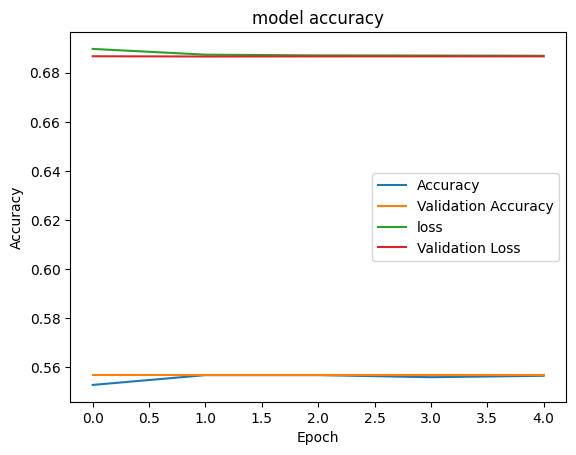

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [ ]:
import pickle
import json

print(f"history object exists: {history is not None}")

# Save the history as a JSON file
with open("efficientnetb0_history.json", "w") as f:
    json.dump(history.history, f)

# Load the previously saved history file
with open("efficientnetb0_history.json", "r") as f:
    history_data = json.load(f)

# Check the available keys
print(history_data.keys())

history object exists: True
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


**Experiment A:** Fine tuning

In [ ]:
for layer in base_model.layers[:-50:]:   # changed it 40 layer because of low val acc
    layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.6976 - loss: 0.5754
Epoch 1: val_accuracy improved from 0.55684 to 0.85930, saving model to efficientnetb0_best.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 452s 546ms/step - accuracy: 0.6977 - loss: 0.5753 - val_accuracy: 0.8593 - val_loss: 0.3537
Epoch 2/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8860 - loss: 0.2950
Epoch 2: val_accuracy improved from 0.85930 to 0.92488, saving model to efficientnetb0_best.keras
706/706 ━━━━━━━━━━━━━━━━━━━━ 337s 478ms/step - accuracy: 0.8861 - loss: 0.2950 - val_accuracy: 0.9249 - val_loss: 0.2036
Epoch 3/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9043 - loss: 0.2429
Epoch 3: val_accuracy did not improve from 0.92488
706/706 ━━━━━━━━━━━━━━━━━━━━ 340s 482ms/step - accuracy: 0.9043 - loss: 0.2429 - val_accuracy: 0.8418 - val_loss: 0.3409
Epoch 4/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9210 - loss: 0.2147
Epoch 4: val_accuracy improved from 0.9248

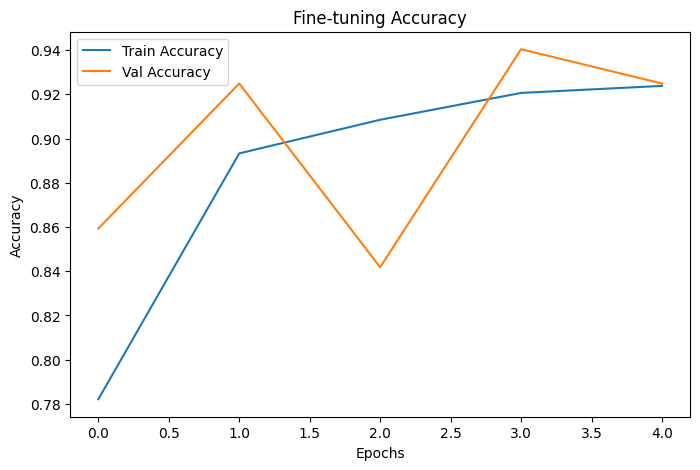

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history_finetune.history["accuracy"], label="Train Accuracy")
plt.plot(history_finetune.history["val_accuracy"], label="Val Accuracy")
plt.title("Fine-tuning Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
import json
model.save("fine_tuned_efficientnetB0.keras")

# Save the fine-tuning history
with open("fine_tune_history.json", "w") as f:
    json.dump(history_finetune.history, f)

print("Fine-tuning complete and history saved!")

Fine-tuning complete and history saved!


In [ ]:
from tensorflow.keras.models import load_model
import json

# Load model
model = load_model("fine_tuned_efficientnetB0.keras")

# Load training history
with open("fine_tune_history.json", "r") as f:
    history_finetune = json.load(f)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
for lr in [1e-3, 1e-4, 1e-5]:
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    # Changed the output layer to match the categorical output of the generators
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    # Changed the loss function to categorical_crossentropy
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f'/kaggle/working/exp1_lr_{lr}.keras', save_best_only=True)
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    print(f"\n Training with LR = {lr}")
    history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[checkpoint, early_stopping])


 Training with LR = 0.001
Epoch 1/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 375s 489ms/step - accuracy: 0.5350 - loss: 0.7049 - val_accuracy: 0.5568 - val_loss: 0.6875
Epoch 2/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 324s 459ms/step - accuracy: 0.5521 - loss: 0.6881 - val_accuracy: 0.4531 - val_loss: 0.6953
Epoch 3/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 327s 463ms/step - accuracy: 0.5682 - loss: 0.6820 - val_accuracy: 0.5568 - val_loss: 0.6870
Epoch 4/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 322s 457ms/step - accuracy: 0.6222 - loss: 0.6297 - val_accuracy: 0.5571 - val_loss: 0.6862
Epoch 5/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 321s 454ms/step - accuracy: 0.6421 - loss: 0.6078 - val_accuracy: 0.5571 - val_loss: 0.6861

 Training with LR = 0.0001
Epoch 1/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 374s 488ms/step - accuracy: 0.5389 - loss: 0.7016 - val_accuracy: 0.4423 - val_loss: 0.7957
Epoch 2/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 318s 451ms/step - accuracy: 0.6019 - loss: 0.6575 - val_accuracy: 0.5588 - val_loss: 0.9291
Epoch 3/5
706/706 ━━━━━━━━━━

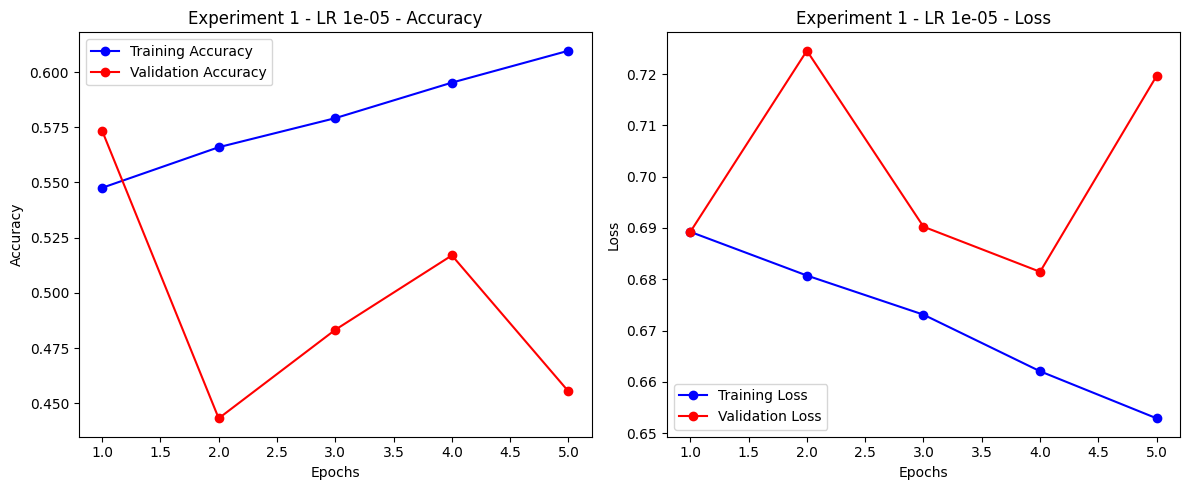

In [ ]:
plot_history(history, f'Experiment 1 - LR {lr}')

In [ ]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

optimizers = {
    "adam": Adam(1e-4),
    "sgd": SGD(learning_rate=1e-3, momentum=0.9),
    "rmsprop": RMSprop(learning_rate=1e-4)
}

for name, opt in optimizers.items():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    # Changed the output layer to match the categorical output of the generators
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    # Changed the loss function to categorical_crossentropy
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f'/kaggle/working/exp2_{name}.keras', save_best_only=True)
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    print(f"\n🚀 Training with {name.upper()}")
    history = model.fit(train_generator, validation_data=val_generator, epochs=3, callbacks=[checkpoint, early_stopping])


🚀 Training with ADAM
Epoch 1/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 389s 507ms/step - accuracy: 0.5337 - loss: 0.7025 - val_accuracy: 0.5145 - val_loss: 0.6877
Epoch 2/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 333s 471ms/step - accuracy: 0.5809 - loss: 0.6678 - val_accuracy: 0.4445 - val_loss: 1.1225
Epoch 3/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 326s 461ms/step - accuracy: 0.6371 - loss: 0.6224 - val_accuracy: 0.5635 - val_loss: 0.8955

🚀 Training with SGD
Epoch 1/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 380s 502ms/step - accuracy: 0.5331 - loss: 0.6932 - val_accuracy: 0.4418 - val_loss: 0.7111
Epoch 2/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 330s 467ms/step - accuracy: 0.5723 - loss: 0.6819 - val_accuracy: 0.5088 - val_loss: 0.6882
Epoch 3/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 331s 468ms/step - accuracy: 0.5796 - loss: 0.6737 - val_accuracy: 0.4427 - val_loss: 0.7618

🚀 Training with RMSPROP
Epoch 1/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 379s 499ms/step - accuracy: 0.5318 - loss: 0.7029 - val_accuracy: 0.4436 - val_loss: 0.7195
Epoch 2/3
706/7

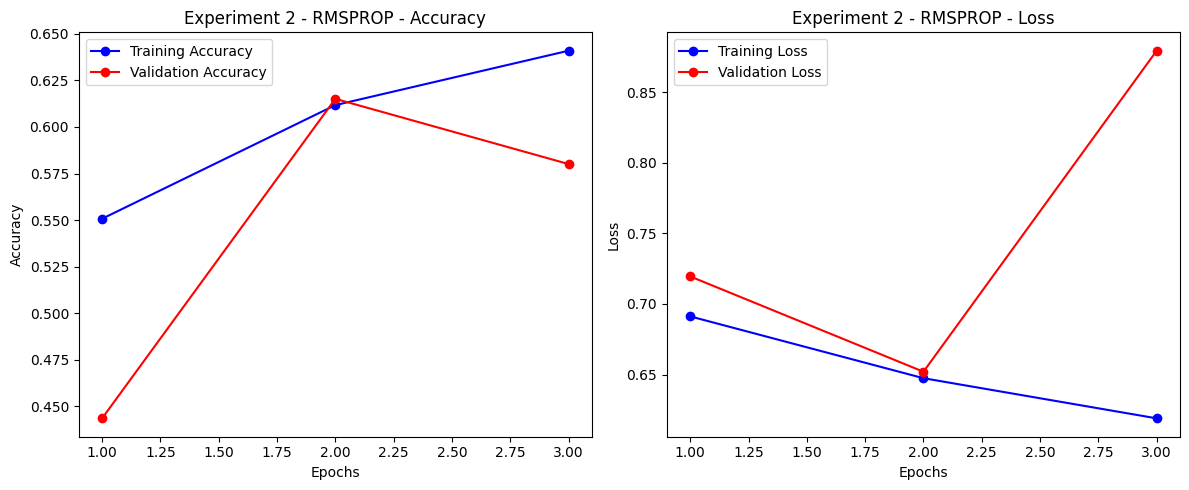

In [ ]:
plot_history(history, f'Experiment 2 - {name.upper()}')

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)
# Changed the output layer to match the categorical output of the generators
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
# Changed the loss function to categorical_crossentropy
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/kaggle/working/exp3_regularization.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=3, callbacks=[checkpoint, early_stopping])


Epoch 1/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 393s 505ms/step - accuracy: 0.5264 - loss: 0.7488 - val_accuracy: 0.5608 - val_loss: 0.7211
Epoch 2/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 325s 460ms/step - accuracy: 0.5674 - loss: 0.7179 - val_accuracy: 0.7013 - val_loss: 0.6762
Epoch 3/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 328s 464ms/step - accuracy: 0.6285 - loss: 0.6703 - val_accuracy: 0.6678 - val_loss: 0.6472


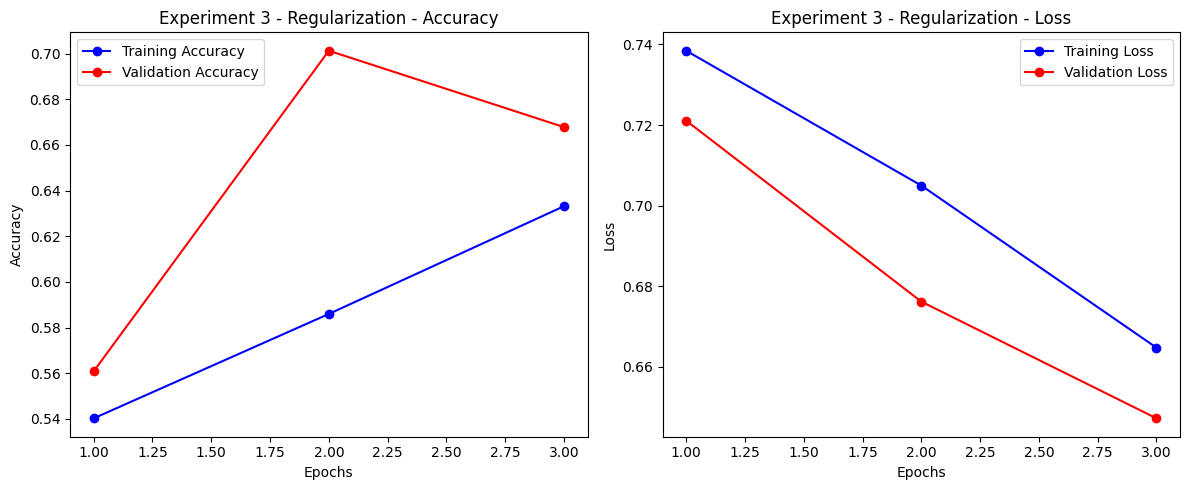

In [ ]:
plot_history(history, 'Experiment 3 - Regularization')

In [ ]:
from tensorflow.keras.layers import LeakyReLU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x)
# Changed the output layer to match the categorical output of the generators
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
# Changed the loss function to categorical_crossentropy
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/kaggle/working/exp4_leakyrelu.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=5, callbacks=[checkpoint, early_stopping])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 383s 497ms/step - accuracy: 0.5430 - loss: 0.6971 - val_accuracy: 0.4387 - val_loss: 0.7206
Epoch 2/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 328s 464ms/step - accuracy: 0.5839 - loss: 0.6631 - val_accuracy: 0.5710 - val_loss: 0.9011
Epoch 3/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 337s 478ms/step - accuracy: 0.6387 - loss: 0.6202 - val_accuracy: 0.6683 - val_loss: 0.6298
Epoch 4/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 322s 456ms/step - accuracy: 0.6516 - loss: 0.6057 - val_accuracy: 0.5637 - val_loss: 0.7371
Epoch 5/5
706/706 ━━━━━━━━━━━━━━━━━━━━ 358s 508ms/step - accuracy: 0.6585 - loss: 0.5958 - val_accuracy: 0.5588 - val_loss: 0.8695


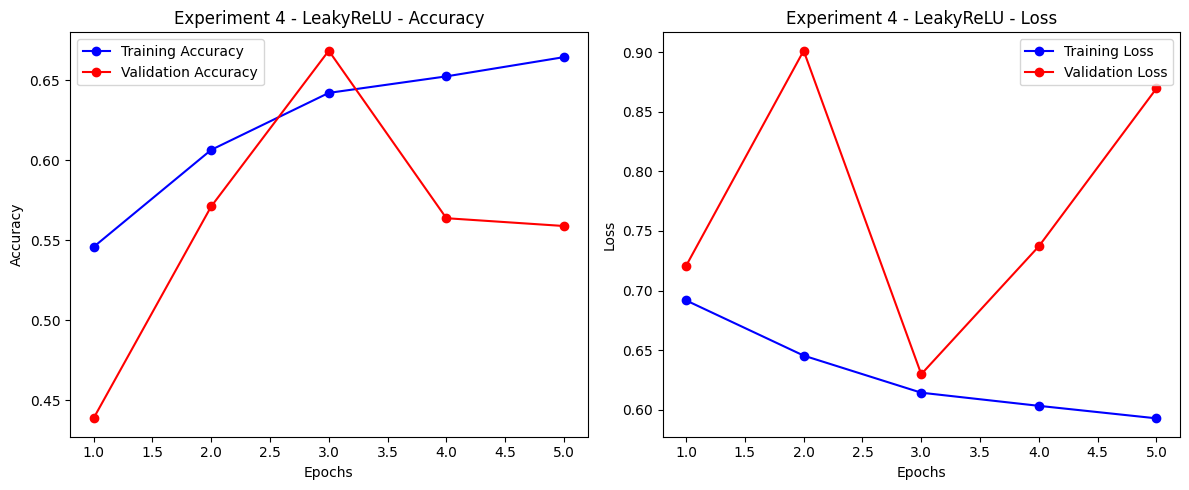

In [ ]:
plot_history(history, 'Experiment 4 - LeakyReLU')

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers[:-50]:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('/kaggle/working/exp5_batchnorm.keras', save_best_only=True)
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint, early_stopping])

save_history(history, 'exp5_batchnorm')
plot_history(history, 'Experiment 5 - Batch Normalization')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from tensorflow.keras.models import load_model
import json
import matplotlib.pyplot as plt


def evaluate_model(model_path, test_generator, experiment_name):
    """
    Evaluate a trained model loaded from a file using Accuracy, Precision, Recall, and F1.
    Saves all results (including confusion matrix and classification report) to JSON.
    """
    print(f"\n Evaluating {experiment_name} ...")

    # Load the model
    try:
        model = load_model(model_path)
    except Exception as e:
        print(f"Error loading model {model_path}: {e}")
        return None

    # 1️ Predict on test data
    y_pred = model.predict(test_generator)
    # For categorical output (2 classes), take the index of the highest probability
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())

    # 2️ Compute metrics
    acc = accuracy_score(y_true, y_pred_classes)
    # Use average='weighted' or 'macro' for multiclass
    prec = precision_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred_classes, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred_classes, average='weighted', zero_division=0)

    print(f" Test Accuracy:  {acc:.4f}")
    print(f" Precision:      {prec:.4f}")
    print(f" Recall:         {rec:.4f}")
    print(f" F1 Score:       {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.show()

    # Save all results
    results = {
        "experiment": experiment_name,
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist()
    }

    # Append to results file
    try:
        with open('/kaggle/working/experiment_results.json', 'a') as f:
            f.write(json.dumps(results) + '\n')
        print(f" Saved metrics for {experiment_name} → /kaggle/working/experiment_results.json")
    except Exception as e:
        print(f"Error saving results for {experiment_name}: {e}")

    return results


 Evaluating initial_training ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step
 Test Accuracy:  0.9264
 Precision:      0.9298
 Recall:         0.9264
 F1 Score:       0.9258


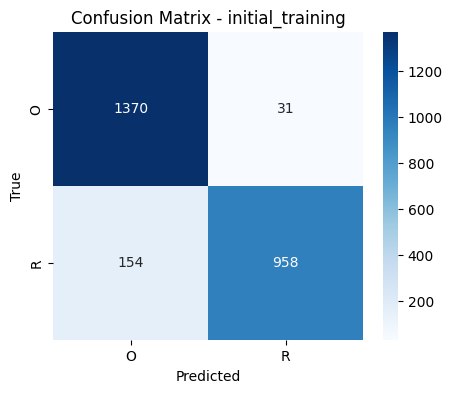

 Saved metrics for initial_training → /kaggle/working/experiment_results.json

 Evaluating fine_tuning ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step
 Test Accuracy:  0.9264
 Precision:      0.9298
 Recall:         0.9264
 F1 Score:       0.9258


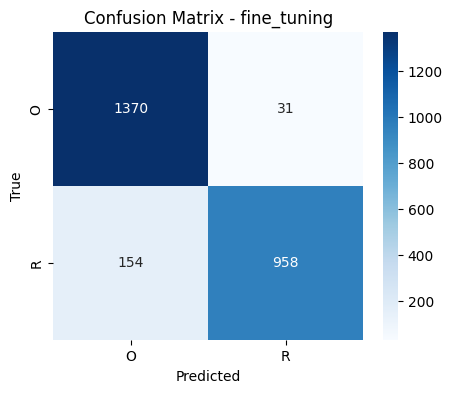

 Saved metrics for fine_tuning → /kaggle/working/experiment_results.json

 Evaluating exp1_lr_0.001 ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step
 Test Accuracy:  0.5575
 Precision:      0.3108
 Recall:         0.5575
 F1 Score:       0.3991


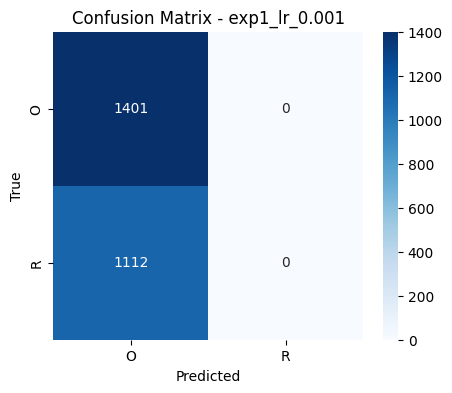

 Saved metrics for exp1_lr_0.001 → /kaggle/working/experiment_results.json

 Evaluating exp1_lr_0.0001 ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 70s 803ms/step
 Test Accuracy:  0.6220
 Precision:      0.6333
 Recall:         0.6220
 F1 Score:       0.5850


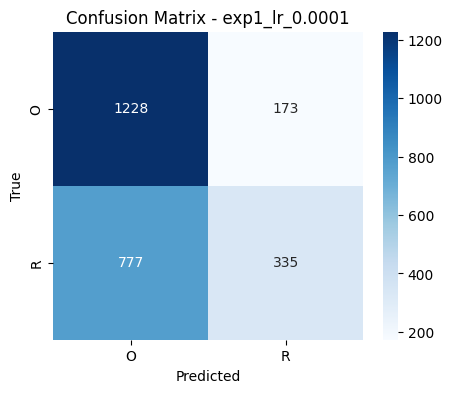

 Saved metrics for exp1_lr_0.0001 → /kaggle/working/experiment_results.json

 Evaluating exp1_lr_1e-05 ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step
 Test Accuracy:  0.5643
 Precision:      0.6914
 Recall:         0.5643
 F1 Score:       0.5176


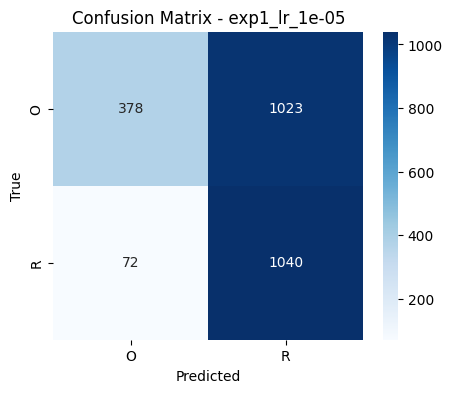

 Saved metrics for exp1_lr_1e-05 → /kaggle/working/experiment_results.json

 Evaluating exp2_adam ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step
 Test Accuracy:  0.6196
 Precision:      0.7102
 Recall:         0.6196
 F1 Score:       0.5977


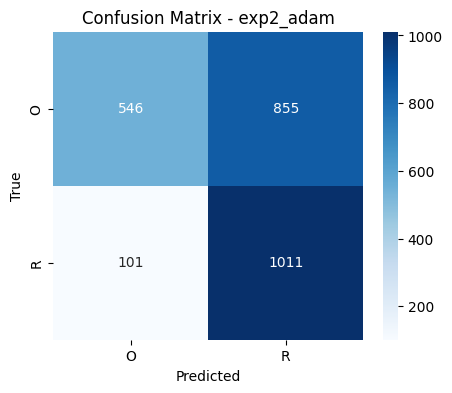

 Saved metrics for exp2_adam → /kaggle/working/experiment_results.json

 Evaluating exp2_sgd ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step
 Test Accuracy:  0.5205
 Precision:      0.6326
 Recall:         0.5205
 F1 Score:       0.4591


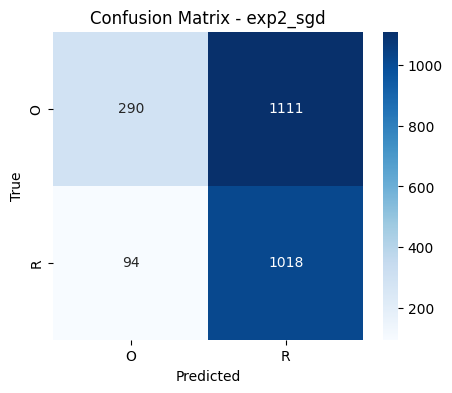

 Saved metrics for exp2_sgd → /kaggle/working/experiment_results.json

 Evaluating exp2_rmsprop ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step
 Test Accuracy:  0.5563
 Precision:      0.5370
 Recall:         0.5563
 F1 Score:       0.5033


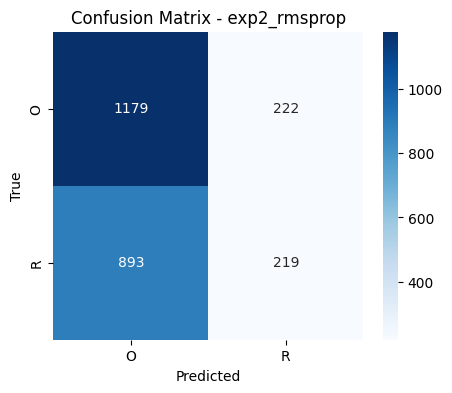

 Saved metrics for exp2_rmsprop → /kaggle/working/experiment_results.json

 Evaluating exp3_regularization ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step
 Test Accuracy:  0.6518
 Precision:      0.7394
 Recall:         0.6518
 F1 Score:       0.5913


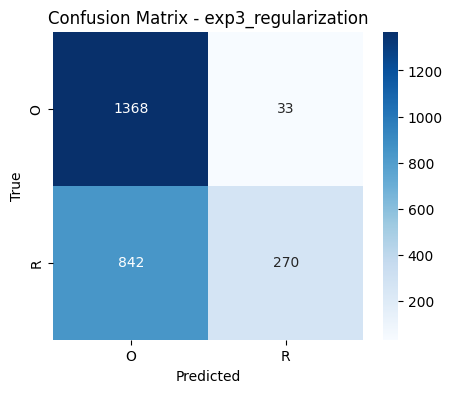

 Saved metrics for exp3_regularization → /kaggle/working/experiment_results.json

 Evaluating exp4_leakyrelu ...
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step
 Test Accuracy:  0.6586
 Precision:      0.6831
 Recall:         0.6586
 F1 Score:       0.6573


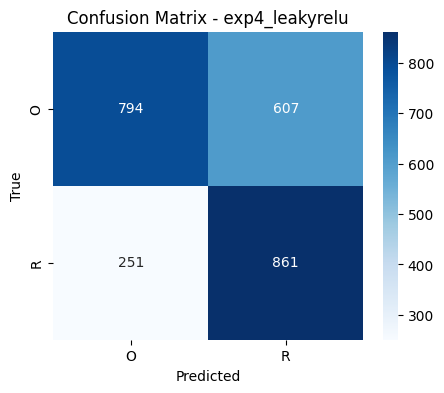

 Saved metrics for exp4_leakyrelu → /kaggle/working/experiment_results.json

 Evaluating exp5_batchnorm ...
Error loading model /kaggle/working/exp5_batchnorm.keras: File not found: filepath=/kaggle/working/exp5_batchnorm.keras. Please ensure the file is an accessible `.keras` zip file.


In [ ]:
# Define a simple save history function as it was used in Experiment 5
def save_history(history, experiment_name):
    try:
        history_dict = history.history
        with open(f'/kaggle/working/{experiment_name}_history.json', 'w') as f:
            json.dump(history_dict, f)
        print(f" Saved history for {experiment_name} → /kaggle/working/{experiment_name}_history.json")
    except Exception as e:
        print(f"Error saving history for {experiment_name}: {e}")


# Evaluate models by loading them
evaluate_model('efficientnetb0_best.keras', test_generator, 'initial_training')

evaluate_model('fine_tuned_efficientnetB0.keras', test_generator, 'fine_tuning')

# Evaluate experiment models by loading them
evaluate_model('/kaggle/working/exp1_lr_0.001.keras', test_generator, 'exp1_lr_0.001')
evaluate_model('/kaggle/working/exp1_lr_0.0001.keras', test_generator, 'exp1_lr_0.0001')
evaluate_model('/kaggle/working/exp1_lr_1e-05.keras', test_generator, 'exp1_lr_1e-05')

evaluate_model('/kaggle/working/exp2_adam.keras', test_generator, 'exp2_adam')
evaluate_model('/kaggle/working/exp2_sgd.keras', test_generator, 'exp2_sgd')
evaluate_model('/kaggle/working/exp2_rmsprop.keras', test_generator, 'exp2_rmsprop')


evaluate_model('/kaggle/working/exp3_regularization.keras', test_generator, 'exp3_regularization')
evaluate_model('/kaggle/working/exp4_leakyrelu.keras', test_generator, 'exp4_leakyrelu')
# Assuming 'exp5_batchnorm.keras' was saved in cell B0xtFAN1VI3M
evaluate_model('/kaggle/working/exp5_batchnorm.keras', test_generator, 'exp5_batchnorm')

**Traditional Machine Learning Models**

The traditional ML models serve as a performance baseline and were trained using manually engineered features extracted from the image dataset. The images were first resized and converted to grayscale to reduce dimensionality. These extracted features were standardized using z-score normalization to ensure uniform scale across models.

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load and Preprocess Data
train_dir = "/content/extracted_datasets/waste-classification-data/DATASET/TRAIN"
test_dir = "/content/extracted_datasets/waste-classification-data/DATASET/TEST" # Updated test directory

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2 # Added validation split for consistency with previous experiments
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', # Changed class_mode to categorical
    shuffle=False, # Keep shuffle False for feature extraction consistency
    subset='training' # Specify training subset
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical', # Changed class_mode to categorical
    shuffle=False # Keep shuffle False for evaluation consistency
)

# Create a validation generator from the training data for feature extraction as done in the keras models
val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [ ]:
# extract Features using EfficientNetB0 (Pretrained)

base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

print("Extracting features from training set...")
X_train = base_model.predict(train_gen, verbose=1)
print("Extracting features from test set...")
X_test = base_model.predict(test_gen, verbose=1)

y_train = train_gen.classes
y_test = test_gen.classes

print(f"Feature shape: {X_train.shape}, Labels: {len(y_train)}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Extracting features from training set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


565/565 ━━━━━━━━━━━━━━━━━━━━ 58s 75ms/step
Extracting features from test set...
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step
Feature shape: (18052, 1280), Labels: 18052


In [11]:
# train Traditional ML Models

results = {}

# Logistic Regression
print("\n🔹 Training Logistic Regression...")
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results["Logistic Regression"] = accuracy_score(y_test, y_pred_lr)

# Random Forest
print("\n Training Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results["Random Forest"] = accuracy_score(y_test, y_pred_rf)

# Support Vector Machine
print("\n Training SVM...")
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
results["SVM (RBF)"] = accuracy_score(y_test, y_pred_svm)

# K-Nearest Neighbors
print("\n Training KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
results["KNN"] = accuracy_score(y_test, y_pred_knn)

# Gradient Boosting / XGBoost (if installed)
try:
    from xgboost import XGBClassifier
    print("\n Training XGBoost...")
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    results["XGBoost"] = accuracy_score(y_test, y_pred_xgb)
except ImportError:
    print(" XGBoost not installed — skipping.")
    results["XGBoost"] = None



🔹 Training Logistic Regression...

 Training Random Forest...

 Training SVM...

 Training KNN...

 Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:54:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Model Performance Summary:
Logistic Regression      : 0.8595
Random Forest            : 0.8778
SVM (RBF)                : 0.9093
KNN                      : 0.9065
XGBoost                  : 0.8957


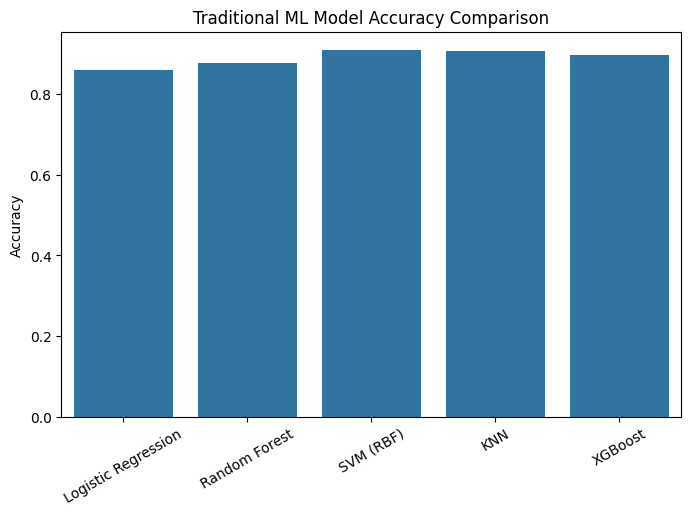

In [12]:

# evaluate & Compare

print("\n Model Performance Summary:")
for model_name, acc in results.items():
    if acc is not None:
        print(f"{model_name:25s}: {acc:.4f}")

# Visualize comparison
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=[v for v in results.values() if v is not None])
plt.title("Traditional ML Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.show()

In [14]:
# save Models
import os

# Create the directory if it doesn't exist
os.makedirs("/kaggle/working/", exist_ok=True)

joblib.dump(lr, "/kaggle/working/logistic_regression_model.pkl")
joblib.dump(rf, "/kaggle/working/random_forest_model.pkl")
joblib.dump(svm, "/kaggle/working/svm_model.pkl")
joblib.dump(knn, "/kaggle/working/knn_model.pkl")
if results["XGBoost"] is not None:
    joblib.dump(xgb, "/kaggle/working/xgboost_model.pkl")

print("\n All models and embeddings saved successfully!")


 All models and embeddings saved successfully!
